In [1]:
from size_based_ecosystem import *
from scipy import stats

In [2]:
depth = 20 #Previously 5 has worked well.
layers = 100 #5 works well.
log_size_range = 12 # 9.5 #8 did NOT work well.
size_classes = 5
t_end = 1/2*1/365
lam = 8
time_step = 1/500000 #One minute #0.00001
res_max = 15
simulate = True
verbose = False
daily_cycle = 365*2*np.pi
mass_vector = np.array([1, 20, 400, 8000, 16000]) #np.array([1, 30, 300, 400, 800, 16000])

In [3]:
obj = spectral_method(depth, layers-1) #This is the old off-by-one error... Now we have added another fucked up error!
logn = stats.lognorm.pdf(obj.x, 1, 0)
print(logn, "Logn")

res_start = 5*logn


water_start = water_column(obj, res_start, layers = layers, resource_max = res_max, time_step = time_step, replacement = lam, advection = 1, diffusion = 0)

params = ecosystem_parameters(mass_vector, obj)
eco = ecosystem_optimization(mass_vector, layers, params, obj, water_start, loss = 'constr')
eco.population_setter(np.array([1, 1, 1, 1, 0.1]) )#, 1, 1, 1, 0.1]))
eco.strategy_setter(np.sqrt(eco.strategy_matrix.flatten())) #This is for the L2 version... Quantum fish ahoy
print(graph_builder(eco), "Original graph")
seq_nash = sequential_nash(eco, verbose = True)
eco.strategy_setter(seq_nash)
print(graph_builder(eco), "New graph")

[0.00000000e+00 3.22007961e-04 1.74146241e-02 9.78424142e-02
 2.42297484e-01 4.02940139e-01 5.35451298e-01 6.19700317e-01
 6.55218082e-01 6.51343007e-01 6.20017925e-01 5.72095676e-01
 5.16015671e-01 4.57707857e-01 4.00994654e-01 3.48112250e-01
 3.00186950e-01 2.57613582e-01 2.20333261e-01 1.88026519e-01
 1.60241792e-01 1.36477367e-01 1.16231149e-01 9.90289288e-02
 8.44387322e-02 7.20764473e-02 6.16062277e-02 5.27379468e-02
 4.52231592e-02 3.88504687e-02 3.34408375e-02 2.88431377e-02
 2.49300957e-02 2.15946907e-02 1.87470123e-02 1.63115555e-02
 1.42249120e-02 1.24338147e-02 1.08934890e-02 9.56626789e-03
 8.42043230e-03 7.42924127e-03 6.57012222e-03 5.82399518e-03
 5.17470913e-03 4.60857174e-03 4.11395694e-03 3.68097727e-03
 3.30121010e-03 2.96746869e-03 2.67361049e-03 2.41437656e-03
 2.18525675e-03 1.98237649e-03 1.80240153e-03 1.64245770e-03
 1.50006319e-03 1.37307137e-03 1.25962239e-03 1.15810218e-03
 1.06710765e-03 9.85417119e-04 9.11965106e-04 8.45820898e-04
 7.86170211e-04 7.322995

1.435450518804517 0.0
1.436048807251246 0.0002534145635396943
1.4366469565750295 0.0004885343698788133
1.4372449701718306 0.0007065493209230397
1.4378428512049883 0.000908622785307079
1.4384406026104315 0.0010958920468515662
1.4390382271018076 0.0012694687465234996
1.439635727175526 0.0014304393180597985
1.4402331051157113 0.0015798654173095005
1.4408303629990769 0.0017187843453653946
1.4414275026997092 0.0018482094655304752
1.4420245258937745 0.001969130614284561
1.442621434064145 0.002082514506248856
1.4432182285049395 0.0021893051332640013
1.4438149103259912 0.0022904241576210036
1.4444114804572379 0.0023867712995970323
1.4450079396530295 0.00247922471924988
1.4456042884963698 0.002568641392670286
1.4462005274030747 0.002655857482684686
1.4467966566258654 0.0027416887040710896
1.447392676258382 0.002826930683440189
1.4479885862391342 0.002912359313754711
1.4485843863553747 0.0029987311036217793
1.44918007624691 0.003086783521399769
1.449775655409838 0.003177235334186346
1.4503711232

1.5555016165543778 0.31865496921626424
1.5560129204263577 0.3219065483986961
1.556523506175869 0.3251687735784868
1.5570333401468368 0.32844153273200954
1.5575424202397394 0.33172471415690236
1.5580507443773053 0.3350182068103031
1.5585583105043819 0.3383219003092901
1.5590651165878056 0.34163568493116764
1.559571160616266 0.3449594516136301
1.5600764406001772 0.34829309195480695
1.5605809545715446 0.3516364982131712
1.561084700583832 0.35498956330733816
1.5615876767118304 0.3583521808157575
1.562089881051527 0.36172424497627786
1.5625913117199715 0.3651056506855925
1.5630919668551475 0.36849629349862284
1.563591844615837 0.37189606962774685
1.5640909431814927 0.3753048759419413
1.5645892607521068 0.3787226099658485
1.565086795548075 0.3821491698787274
1.5655835458970364 0.3855844545048005
1.5660795100591025 0.38902836332612684
1.5665746862288228 0.39248079648451684
1.5670690727921177 0.39594165475648035
1.567562667984256 0.39941083958167084
1.568055470145346 0.4028882530401332
1.56854

1.6468831071665542 1.137173933079286
1.6472092225549368 1.1410270775868199
1.647534468251832 1.1448782313324932
1.6478588446551226 1.148727370591549
1.6481823521674461 1.1525744718044393
1.648504991196171 1.156419511575847
1.6488267621533588 1.1602624666736472
1.6491476654557313 1.1641033140279047
1.6494677015246417 1.167942030729884
1.6497868707860404 1.171778594031076
1.6501051736704415 1.1756129813421876
1.650422610612897 1.1794451702322155
1.6507391820529598 1.1832751384274727
1.6510548884346532 1.1871028638106584
1.6513697302064405 1.1909283244199071
1.651683707821195 1.1947514984478869
1.6519968217361694 1.198572364240854
1.6523090724129634 1.2023909002977688
1.6526204603174945 1.2062070852694067
1.6529309859199686 1.2100208979574467
1.6532406496948462 1.213832317313601
1.653549452120819 1.2176413224387532
1.6538573936807746 1.2214478925821148
1.6541644748617688 1.2252520071403399
1.6544706961549973 1.2290536456566798
1.654776058055766 1.2328527878201998
1.6550805610634605 1.2366

1.6985621952319778 1.9048775137500615
1.698713092655887 1.907946583469799
1.6988632776787194 1.9110112664517533
1.6990127511828694 1.9140715610254229
1.699161514051096 1.9171274655760135
1.6993095671665053 1.9201789785441057
1.699456911412542 1.9232260984254017
1.6996035476729783 1.9262688237704297
1.699749476831903 1.9293071531842279
1.6998946997737097 1.9323410853260823
1.7000392173830874 1.9353706189091908
1.7001830305450092 1.9383957527004247
1.7003261401447198 1.9414164855200196
1.7004685470677265 1.9444328162412499
1.7006102521997892 1.9474447437901967
1.7007512564269074 1.9504522671453994
1.7008915606353119 1.9534553853376042
1.7010311657114536 1.9564540974494404
1.7011700725419938 1.9594484026151486
1.7013082820137926 1.9624383000202528
1.701445795013897 1.9654237889013348
1.7015826124295361 1.9684048685456654
1.7017187351481058 1.9713815382909547
1.7018541640571603 1.9743537975250638
1.701988900044403 1.9773216456856861
1.7021229439760748 1.9802850819416926
1.7022562952870417 

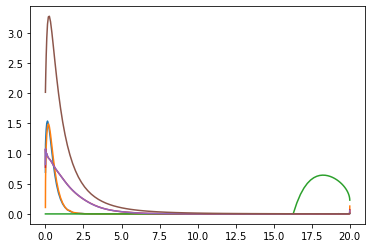

[1.00063048 1.00095627 0.99999999 1.         0.1       ] [0.63994202 0.96371121 0.         0.         0.        ]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[2.01550266e+00 2.11743776e+00 2.34235998e+00 2.62988570e+00
 2.91859741e+00 3.14256547e+00 3.26570447e+00 3.27557819e+00
 3.18314310e+00 3.00890094e+00 2.78273018e+00 2.52477623e+00
 2.25932793e+00 1.99631084e+00 1.74963470e+00 1.52080406e+00
 1.31628317e+00 1.13315730e+00 9.73940296e-01 8.34158680e-01
 7.14623382e-01 6.10778823e-01 5.22877329e-01 4.46875662e-01
 3.82954836e-01 3.27732843e-01 2.81484244e-01 2.41448399e-01
 2.08019777e-01 1.78958217e-01 1.54755036e-01 1.33583799e-01
 1.15998763e-01 1.00494543e-01 8.76580120e-02 7.62307404e-02
 6.68093692e-02 5.83254731e-02 5.13698944e-02 4.50212332e-02
 3.98547965e-02 3.50639771e-02 3.12030621e-02 2.75560321e-02
 2.46535943e-02 2.18520262e-02 1.96578189e-02 1.74855878e-02
 1.58181847e-02 1.41177790e-02 1.28448866e-02 1.15007822e-02
 1

In [4]:
if simulate is True:
    time_span = np.linspace(0, t_end, int(t_end/time_step))

    for t in time_span:
        eco.population_setter(eco.total_growth()*time_step + eco.populations)
#        print(eco.water.res_counts, "Before eating")

        eco.consume_resources(time_step)
 #       print(eco.water.res_counts, "After eating")
        eco.water.update_resources()
#        opt_obj = optm.minimize(
#            lambda x: loss_func(eco.loss_function(x), size_classes=size_classes, layers=layers, spec=obj),
#            x0=eco.strategy_matrix.flatten(), method='SLSQP', constraints=constr, bounds=bounds)
        eco.parameters.layered_attack = 1/2*(1.00001+np.cos(t*daily_cycle))*params.layered_attack
        x_res = sequential_nash(eco, verbose = verbose)
        eco.strategy_setter(x_res)
        #print(eco.populations, min(eco.water.res_counts), max(eco.water.res_counts), eco.total_growth(x_res))

        #print(t)

    plt.figure()
    for i in range(size_classes):
        plt.plot(obj.x, x_res[i * layers:(i + 1) * layers])
    plt.plot(obj.x, eco.water.res_counts)
    plt.show()
    print(eco.populations, eco.total_growth(x_res))
    print(graph_builder(eco))
    print(eco.water.res_counts)
    print(np.dot(eco.water.res_counts, np.dot(eco.spectral.M, eco.strategy_matrix[0])))

In [5]:
eco.total_growth(eco.strategy_matrix.flatten())

array([0.63994202, 0.96371121, 0.        , 0.        , 0.        ])

In [6]:
    A, one, bounds = constraint_builder(eco.spectral.M, eco.mass_vector.shape[0])
    constr1 = ({'type': 'eq', 'fun': lambda x: np.dot(A[0, 0:eco.layers], x**2) - 1})
    bounds1 = optm.Bounds(np.array([0] * eco.layers), np.array([np.inf] * eco.layers))
x_temp = np.copy(eco.strategy_matrix.flatten())

In [7]:
eco.strategy_matrix

array([[6.91370534e-01, 1.14957168e+00, 1.27131995e+00, 1.40170392e+00,
        1.50361530e+00, 1.53856913e+00, 1.49594284e+00, 1.38332964e+00,
        1.22016209e+00, 1.02781295e+00, 8.28781533e-01, 6.39897211e-01,
        4.76345361e-01, 3.43838077e-01, 2.41838721e-01, 1.64557697e-01,
        1.08473040e-01, 6.95581701e-02, 4.32649395e-02, 2.56972272e-02,
        1.07392796e-02, 9.07817002e-03, 7.80851743e-03, 2.72506425e-03,
        1.95901869e-03, 8.25174930e-04, 8.76917168e-04, 1.69406589e-19,
        2.46576517e-04, 9.85244476e-05, 2.32009605e-05, 0.00000000e+00,
        2.20228566e-20, 4.44580279e-06, 7.34765151e-21, 4.83956235e-21,
        2.57746894e-21, 3.79882696e-22, 5.34439770e-07, 1.24485557e-08,
        6.84861020e-08, 6.76692767e-08, 2.88220745e-23, 1.49399712e-08,
        1.07533480e-23, 7.44079427e-09, 3.56721639e-24, 0.00000000e+00,
        1.31831910e-24, 3.42885912e-09, 7.62802284e-09, 4.52812858e-09,
        2.08863105e-23, 0.00000000e+00, 2.86765870e-09, 1.654808

In [8]:
x0 = eco.water.res_counts/(np.dot(eco.ones, np.dot(eco.water.spectral.M, eco.water.res_counts)))

In [9]:
optm.minimize(lambda x: -eco.one_actor_growth(eco.strategy_replacer(x, 0, x_temp), 0),
                x0=eco.strategy_matrix[0], method='SLSQP', constraints=constr1, bounds=bounds1)

     fun: -0.6395388086204323
     jac: array([-5.31241298e-04, -3.41419131e-03, -6.67880476e-03, -1.05186552e-02,
       -1.46494880e-02, -1.84596106e-02, -2.13301778e-02, -2.28197202e-02,
       -2.28043273e-02, -2.14301124e-02, -1.90755874e-02, -1.61392987e-02,
       -1.30550712e-02, -1.01127997e-02, -7.54106790e-03, -5.41745126e-03,
       -3.76869738e-03, -2.53924727e-03, -1.66562200e-03, -1.06314570e-03,
       -6.63727522e-04, -4.04737890e-04, -2.42330134e-04, -1.42127275e-04,
       -8.20979476e-05, -4.65512276e-05, -2.60621309e-05, -1.43498182e-05,
       -7.81565905e-06, -4.19467688e-06, -2.22027302e-06, -1.16229057e-06,
       -6.03497028e-07, -3.12924385e-07, -1.63912773e-07, -8.19563866e-08,
       -4.47034836e-08, -1.49011612e-08, -1.49011612e-08,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0

In [10]:
new

NameError: name 'new' is not defined

In [ ]:
np.dot(new_dist, np.dot(obj.M, x0))

In [ ]:
np.dot(eco.strategy_matrix.flatten()[eco.layers:2*eco.layers], np.dot(obj.M, x0))

In [ ]:
foraging_payoff_new = eco.parameters.layered_foraging[:,1]*new_dist*eco.water.res_counts*eco.parameters.clearance_rate[1]

foraging_payoff = eco.parameters.layered_foraging[:,1]*eco.strategy_matrix[1]*eco.water.res_counts*eco.parameters.clearance_rate[1]

In [ ]:
np.dot(eco.ones, np.dot(obj.M, foraging_payoff_new))/(1+np.dot(eco.ones, np.dot(obj.M, eco.parameters.handling_times[i]*foraging_payoff_new)))

In [ ]:
eco.one_actor_growth(eco.strategy_replacer(new_dist, 1, eco.strategy_matrix.flatten()), 1)

In [ ]:
eco.one_actor_growth(eco.strategy_matrix.flatten(), 1)

In [ ]:
plt.plot(obj.x, eco.strategy_matrix[4])